In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [12]:
class LinearRegression:
    
    def __init__(self, X, y, learningRate, maxIter, epsilon,  
                 regularization = False, regularizationRate=0, batch=10, optimizer = 'GD',error='SSE') -> None:
        self.X = X
        self.y = y
        self.learningRate = learningRate
        self.maxIter = maxIter
        self.epsilon = epsilon
        self.error = error
        self.regularization = regularization
        self.regularizationRate = regularizationRate
        self.batch = batch
        self.optimizer = optimizer
    
    def split_data(self):
        train_X, train_y, test_X, test_y = train_test_split(self.X, self.y, test_size=0.3, shuffle=True)
        return train_X, train_y, test_X, test_y
    
    def add_init_col(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])
    
    def normalise(self, X):
        mean = np.mean(X, 0)
        std = np.std(X, 0)
        X_norm = (X-mean)/std
        X_norm = self.add_init_col(X_norm)
        return X_norm, mean, std
    
    def normalizeTestData(self, X, train_mean, train_std):

        X_norm = (X - train_mean) / train_std
        X_norm = self.add_init_col(X_norm)
        return X_norm
    
    def rank(self, X):
        u, s, v = np.linalg.svd(X)
        return len([x for x in s if x>0.0005])
    
    def full_rank(self, X):
        rank = self.rank(X)
        if rank == min(X.shape):
            self.full_rank = True
            print("Matrix is Full Rank")
        else:
            self.full_rank = False
            print("Matrix not Full Rank")
    
    def check_lowRank(self, X):
        if X.shape[0] < X.shape[1]:
            self.check_lowRank = True
            print("Matrix is Low Rank")
        else:
            self.check_lowRank = False
            print("Matrix is not Low Rank")
    
    def closedFormSolution(self, X, y):
        if self.regularization:
            self.theta = np.linalg.inv((X.T.dot(X))+(self.regularizationRate *
            np.identity(X.shape[1]))).dot(X.T).dot(y)
        else:
            self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        return self.theta
    
    def predict(self, X):
        return X.dot(self.theta)
    
    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()
    
    def rmse(self, X, y):
        return np.sqrt(((self.sse(X, y)).sum()) / X.shape[0])
    
    def cost_function(self, X, y):
        return self.sse(X, y)/2
    
    def cost_derivative(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y).dot(X)
    
    def gradient_descent(self, X, y):
        print('Using Gradient Descent')
        errors = []
        last_error =  float('inf')

        if self.regularization:
          print('Using Regularization')
          for i in tqdm(range(self.maxIter)):
            self.theta = self.theta - self.learningRate * (self.cost_derivative(X, y) + (self.regularizationRate + self.theta))
          
            if self.error == 'RMSE':
                  current_error = self.rmse(X, y)
            else:
                  current_error = self.sse(X,y)
            diff = last_error - current_error
            last_error = current_error
            errors.append(current_error)
            if diff < self.epsilon:        
                  print('Model has stopped learning')
                  break

        else:
          print('Without Regularization')
          for i in tqdm(range(self.maxIter)):
            self.theta = self.theta - self.learningRate * self.cost_derivative(X, y)
          
            if self.error == 'RMSE':
                  current_error = self.rmse(X, y)
            else:
                  current_error = self.sse(X,y)
            diff = last_error - current_error
            last_error = current_error
            errors.append(current_error)
            if diff < self.epsilon:        
                  print('Model has stopped learning')
                  break
                       
        self.plot_rmse(errors)
    
    def stochasticGradientDescent(self, X, y):
        print('Using Stochastic Gradient Descent')
        errors = []
        last_error = float('inf')

        if self.regularization:    
            print('Using regularization')
            for i in tqdm(range(self.maxIter)):
                index = np.arange(X.shape[0])
                np.random.shuffle(index)
                X = X[index]
                y = y[index]
                X = X[0:self.batch]
                y = y[0:self.batch]
                self.theta = self.theta - self.learningRate * (self.cost_derivative(X, y) +
                 (self.regularizationRate * self.theta))
                if self.error == 'RMSE':
                    current_error = self.rmse(X, y)
                else:
                    current_error = self.sse(X,y)
                diff = last_error - current_error
                last_error = current_error
                errors.append(current_error)
                if diff < self.epsilon:        
                    print('Model has stopped learning')
                    break

        else:
            print('Not using regularization')
            for i in tqdm(range(self.maxIter)):
                index = np.arange(X.shape[0])
                np.random.shuffle(index)
                X = X[index]
                y = y[index]
                X = X[0:self.batch]
                y = y[0:self.batch]
                self.theta = self.theta - self.learningRate * self.cost_derivative(X, y)
                if self.error == 'RMSE':
                    current_error = self.rmse(X, y)
                else:
                    current_error = self.sse(X,y)
                diff = last_error - current_error
                last_error = current_error
                errors.append(current_error)
                if diff < self.epsilon:        
                    print('Model has stopped learning')
                    break

        self.plot_rmse(errors)

    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel=self.error,
               title='{} trend'.format(self.error))
        ax.grid()

        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()    
    

    def fit(self):
        X_train, X_test, y_train, y_test = self.split_data()
        
        X_train ,mean ,std = self.normalise(X_train)
        X_test = self.normalizeTestData(X_test, mean, std)
                
        self.full_rank(X_train)
        self.check_lowRank(X_train)
        
        
        if (self.full_rank and not self.check_lowRank and self.optimizer=='Normal' and X_train.shape[0] < 10000):
            print("Solving using Normal equation")
            self.w = self.closedFormSolution(X_train, y_train)
            
        else:

            if self.optimizer == 'SGD':
                print('Solving using stochastic gradient descent')
                self.theta = np.ones(X_train.shape[1], dtype = np.float16)*0
                self.stochasticGradientDescent(X_train, y_train)

            else:
                print('Solving using gradient descent')
                self.theta = np.ones(X_train.shape[1], dtype = np.float16)*0
                self.gradient_descent(X_train, y_train)
            
        print(self.theta)
        print('SSE_test:', self.sse(X_test, y_test))
        print('RMSE_test:', self.rmse(X_test, y_test))


        


### Housing Dataset 

In [4]:
df = pd.read_csv('housing.csv')
X = df.values[:,:-1]
y = df.values[:, -1]

#### Using Closed Form Solution

In [31]:
lr = LinearRegression(X, y, learningRate=0.0004, epsilon=0.005, maxIter=50000, regularization = True, regularizationRate=1, batch=100, optimizer = 'Normal', error='RMSE')

In [32]:
lr.fit()

Matrix is Full Rank
Matrix is not Low Rank
Solving using Normal equation
[10.19804651  1.25403444  0.11706623  0.72110034 -0.21254047 -0.16796592
 11.70197204]
SSE_test: 9401.85239834412
RMSE_test: 10.05461024003263


#### Using Gradient Descend

Matrix is Full Rank
Matrix is not Low Rank
Solving using gradient descent
Using Gradient Descent
Using Regularization


  0%|          | 36/50000 [00:00<00:04, 11537.78it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


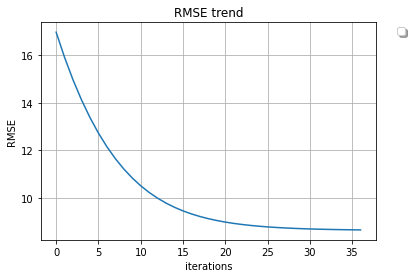

[ 9.7752831   0.50165457 -0.33887626  0.1724297  -0.05397124 -0.14785668
 11.79156599]
SSE_test: 8249.791421479767
RMSE_test: 9.418462435003253


In [33]:
lr = LinearRegression(X, y, learningRate=0.0004, epsilon=0.005, maxIter=50000, regularization = True, regularizationRate=1, batch=100, optimizer = 'GD', error='RMSE')
lr.fit()

#### Using Stochiastic Gradient Descend

Matrix is Full Rank
Matrix is not Low Rank
Solving using stochastic gradient descent
Using Stochastic Gradient Descent
Using regularization


  0%|          | 67/50000 [00:00<00:04, 10376.19it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


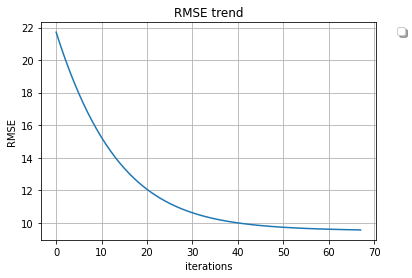

[11.29972483  0.45505673 -1.67394843 -0.69759252 -0.43544    -1.03750007
 13.67429077]
SSE_test: 8077.983546547515
RMSE_test: 9.319873289638627


In [34]:
lr = LinearRegression(X, y, learningRate=0.0004, epsilon=0.005, maxIter=50000, regularization = True, regularizationRate=1, batch=100, optimizer = 'SGD', error='RMSE')
lr.fit()

### Concrete Dataset

In [18]:
df = pd.read_csv('concreteData.csv')
X = df.values[:,0:-1]
y = df.values[:, -1]

In [16]:
df

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
...,...,...,...,...,...,...,...,...,...
1024,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1025,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1026,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1027,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


#### Closed Form Solution

In [44]:
lr = LinearRegression(X, y, learningRate=0.007, epsilon=0.001, maxIter=50000, regularization = True, regularizationRate=1, batch=100, optimizer = 'Normal', error='RMSE')
lr.fit()

Matrix is Full Rank
Matrix is not Low Rank
Solving using Normal equation
[11.09725581  0.36778835 -0.66885967 -0.22074568  0.25002501 -0.2655848
 12.3158161 ]
SSE_test: 6633.316338333896
RMSE_test: 8.445471101875995


#### Using Gradient Descend

Matrix is Full Rank
Matrix is not Low Rank
Solving using gradient descent
Using Gradient Descent
Using Regularization


  0%|          | 3/50000 [00:00<00:23, 2121.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


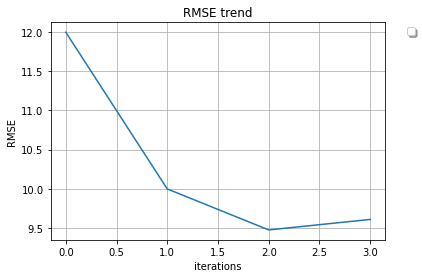

[ 9.72217234 -0.57958915  0.91658524  1.15634865  1.59665931 -0.05169301
 11.16131176]
SSE_test: 7967.343234037925
RMSE_test: 9.255828291149664


In [45]:
lr = LinearRegression(X, y, learningRate=0.007, epsilon=0.001, maxIter=50000, regularization = True, regularizationRate=1, batch=100, optimizer = 'GD', error='RMSE')
lr.fit()

#### Using Stochiastic Gradient Descend 

Matrix is Full Rank
Matrix is not Low Rank
Solving using stochastic gradient descent
Using Stochastic Gradient Descent
Using regularization


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 6/50000 [00:00<00:20, 2483.55it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


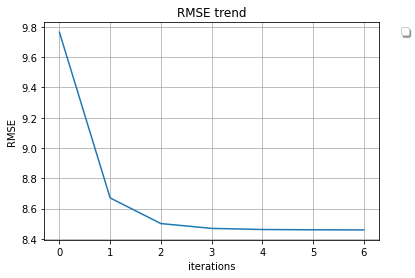

[ 9.706268    0.74642809  0.66633829 -0.1797892  -0.46737765  0.46463833
 11.37877217]
SSE_test: 7110.588489414539
RMSE_test: 8.744023144205011


In [46]:
lr = LinearRegression(X, y, learningRate=0.007, epsilon=0.001, maxIter=50000, regularization = True, regularizationRate=1, batch=100, optimizer = 'SGD', error='RMSE')
lr.fit()

### Yatch Dataset

In [26]:
df = pd.read_csv('yachtData.csv')
X = df.values[:, 0:-1]
y = df.values[:, -1]

In [27]:
df

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82
...,...,...,...,...,...,...,...
302,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
303,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
304,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
305,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


#### Using Closed Form Solution

In [47]:
lr = LinearRegression(X, y, learningRate=0.01, epsilon=0.01, maxIter=50000, regularization = True, regularizationRate=1, batch=100, optimizer = 'Normal', error='RMSE')
lr.fit()

Matrix is Full Rank
Matrix is not Low Rank
Solving using Normal equation
[11.33506977  0.47233737 -0.92950646 -1.19085431  0.67174291  0.89837645
 13.2846523 ]
SSE_test: 6232.46814185305
RMSE_test: 8.186317027304659


#### Using Gradient Descend

Matrix is Full Rank
Matrix is not Low Rank
Solving using gradient descent
Using Gradient Descent
Using Regularization


  0%|          | 1/50000 [00:00<00:29, 1678.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


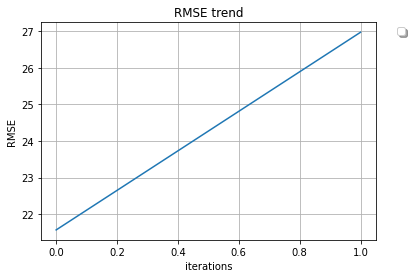

[-3.56838     2.3127526   2.24892517 -3.94890181  2.40402574 -6.1178134
 -4.46270874]
SSE_test: 47959.40958396782
RMSE_test: 22.70886558531044


In [48]:
lr = LinearRegression(X, y, learningRate=0.01, epsilon=0.01, maxIter=50000, regularization = True, regularizationRate=1, batch=100, optimizer = 'GD', error='RMSE')
lr.fit()

#### using Stochiastic Gradient Descend

Matrix is Full Rank
Matrix is not Low Rank
Solving using stochastic gradient descent
Using Stochastic Gradient Descent
Using regularization


  0%|          | 5/50000 [00:00<00:12, 3922.11it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model has stopped learning


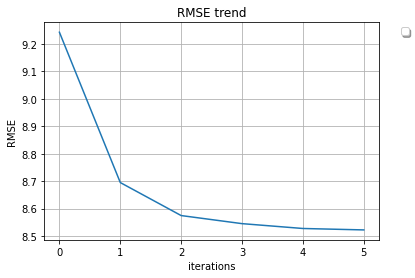

[10.56737179  1.38341392  0.37201462 -0.4498771  -0.27547684 -0.14335984
 11.85511123]
SSE_test: 8670.16867820589
RMSE_test: 9.655445106040542


In [49]:
lr = LinearRegression(X, y, learningRate=0.01, epsilon=0.01, maxIter=50000, regularization = True, regularizationRate=1, batch=100, optimizer = 'SGD', error='RMSE')
lr.fit()